# Proyecto Integrador: An√°lisis Supervisado
**Estudiantes:** 
- Jonathan David Ayala Garcia
- Hernandez Ramirez Adrian
- Andres Isai Acosta Guerra
- Jaime Casta√±eda Rodriguez

**Asignatura:** Extracci√≥n de Conocimiento en Bases de Datos  
**Unidad:** III - An√°lisis Supervisado  
**Docente:** Ing. Maximiliano Carsi Castrej√≥n  

## Descripci√≥n del Dataset
Este proyecto utiliza un dataset preprocesado sobre residuos peligrosos, con datos anuales por entidad federativa, tipo de residuo, subsector y generaci√≥n estimada. El objetivo es aplicar t√©cnicas de an√°lisis supervisado para predecir la generaci√≥n de residuos y clasificar los tipos de residuos.

## Objetivos
- Aplicar regresi√≥n lineal simple para predecir generaci√≥n estimada usando una sola variable.
- Aplicar regresi√≥n lineal m√∫ltiple con m√∫ltiples variables predictoras.
- Clasificar tipos de residuos usando KNN.


In [13]:
import pandas as pd
import numpy as np
from sklearn.utils.multiclass import unique_labels
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Configuraci√≥n de visualizaciones
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)




In [14]:
conn = sqlite3.connect("incidencia_delictiva.db")
# Cambia el nombre de la tabla si es necesario para la nueva base de datos
df = pd.read_sql_query("SELECT * FROM incidencia_delictiva", conn)
conn.close()
df.head()

Anio  Clave_Entidad         Entidad Bien_Juridico_Afectado  \
0  2015              1  Aguascalientes          El Patrimonio   
1  2015              1  Aguascalientes          El Patrimonio   
2  2015              1  Aguascalientes          El Patrimonio   
3  2015              1  Aguascalientes          El Patrimonio   
4  2015              1  Aguascalientes          El Patrimonio   

          Tipo_Delito      Subtipo_Delito           Modalidad        Mes  \
0  Abuso De Confianza  Abuso De Confianza  Abuso De Confianza      Abril   
1  Abuso De Confianza  Abuso De Confianza  Abuso De Confianza     Agosto   
2  Abuso De Confianza  Abuso De Confianza  Abuso De Confianza  Diciembre   
3  Abuso De Confianza  Abuso De Confianza  Abuso De Confianza      Enero   
4  Abuso De Confianza  Abuso De Confianza  Abuso De Confianza    Febrero   

        Fecha  Incidencia_Delictiva  
0  2015-04-01                    22  
1  2015-08-01                    40  
2  2015-12-01                    26  
3  2015-01-01                    41  
4  2015-02-01                    33

## 2. Exploraci√≥n de Datos

### Estad√≠sticas Descriptivas


In [15]:
# Aseg√∫rate de que df est√° correctamente cargado de la base de datos
if 'df' in locals():
    df.describe(include='all')
else:
    print('Error: No se pudo cargar el DataFrame desde la base de datos.')

## 3. Regresi√≥n Lineal Simple

Aplicamos una regresi√≥n lineal simple para predecir la variable `Generacion_Estimada` en funci√≥n de una sola variable independiente. Se analiza su relaci√≥n con una gr√°fica de dispersi√≥n y se eval√∫a el modelo con m√©tricas como R¬≤, MSE y RMSE.


In [16]:
# Usar todos los datos originales para regresi√≥n lineal simple
df['y'] = df['Incidencia_Delictiva']  # Ahora s√≠ existe y es num√©rica
display(df.head())

Anio  Clave_Entidad         Entidad Bien_Juridico_Afectado  \
0  2015              1  Aguascalientes          El Patrimonio   
1  2015              1  Aguascalientes          El Patrimonio   
2  2015              1  Aguascalientes          El Patrimonio   
3  2015              1  Aguascalientes          El Patrimonio   
4  2015              1  Aguascalientes          El Patrimonio   

          Tipo_Delito      Subtipo_Delito           Modalidad        Mes  \
0  Abuso De Confianza  Abuso De Confianza  Abuso De Confianza      Abril   
1  Abuso De Confianza  Abuso De Confianza  Abuso De Confianza     Agosto   
2  Abuso De Confianza  Abuso De Confianza  Abuso De Confianza  Diciembre   
3  Abuso De Confianza  Abuso De Confianza  Abuso De Confianza      Enero   
4  Abuso De Confianza  Abuso De Confianza  Abuso De Confianza    Febrero   

        Fecha  Incidencia_Delictiva   y  
0  2015-04-01                    22  22  
1  2015-08-01                    40  40  
2  2015-12-01                    26  26  
3  2015-01-01                    41  41  
4  2015-02-01                    33  33

In [17]:
# Solo continuar si la columna 'y' existe
if 'y' in df.columns:
    #2. Correlacion de Pearson
    def correlacion_pearson(x, y):
        X_mean = np.mean(x)
        Y_mean = np.mean(y)
        numerator = np.sum((x - X_mean) * (y - Y_mean))
        denominator = np.sqrt(np.sum((x - X_mean) ** 2) * np.sum((y - Y_mean) ** 2))
        return numerator / denominator
    #3. Calcular las ventas
    def calcular_parametros(x, y):
        x_mean = np.mean(x)
        y_mean = np.mean(y)
        beta1 = np.sum((x - x_mean) * (y - y_mean)) / np.sum((x - x_mean) ** 2)
        beta0 = y_mean - beta1 * x_mean
        return beta0, beta1
else:
    print("No se puede continuar: la columna 'y' no existe en el DataFrame agrupado.")

In [18]:
# Determinar las correlaciones solo si la columna 'y' existe
if 'y' in df.columns:
    correlaciones = {}
    columnas_numericas = df.select_dtypes(include=[np.number]).columns.drop('y')
    for columna in columnas_numericas:
        corr = correlacion_pearson(df[columna], df['y'])
        correlaciones[columna] = abs(corr)  # Valor absoluto para comparar
    # Seleccionar variable con mayor correlaci√≥n
    mejor_variable = max(correlaciones, key=correlaciones.get)
    print(f"Mejor candidato de X es: {mejor_variable}")
    print(f"Correlaci√≥n: {correlaciones[mejor_variable]:.4f}")
else:
    print("No se puede calcular correlaciones: la columna 'y' no existe en el DataFrame.")

Mejor candidato de X es: Incidencia_Delictiva
Correlaci√≥n: 1.0000


In [19]:
# Resolver la ecuacion de la regresion solo si existen las variables necesarias
if 'mejor_variable' in locals() and 'y' in df.columns and mejor_variable in df.columns:
    x = df[mejor_variable].values
    y = df['y'].values
    beta0, beta1 = calcular_parametros(x, y)
    print(f"El valor de beta1 es: {beta1}")
    print(f"El valor de beta0 es: {beta0}")
else:
    print("No se puede resolver la regresi√≥n: faltan variables necesarias.")

El valor de beta1 es: 1.0
El valor de beta0 es: 0.0


In [20]:
# Funcion para realizar la predicciones
def hacer_prediccion(x_nuevo, beta0, beta1):
    return beta0 + beta1 * x_nuevo

if 'x' in locals() and 'beta0' in locals() and 'beta1' in locals():
    y_prediccion = hacer_prediccion(x, beta0, beta1)
    print("Valores reales de y:")
    print(y)
    print("Valores predichos de y:")
    print(y_prediccion)
else:
    print("No se puede hacer la predicci√≥n: faltan variables necesarias.")

Valores reales de y:
[ 22  40  26 ... 102 178  97]
Valores predichos de y:
[ 22.  40.  26. ... 102. 178.  97.]


In [21]:
# Calcular r2 y mse solo si existen las variables necesarias
if 'y' in locals() and 'y_prediccion' in locals():
    def calcular_r2(y_real, y_pred):
        ss_res = np.sum((y_real - y_pred) ** 2)
        ss_tot = np.sum((y_real - np.mean(y_real)) ** 2)
        return 1 - (ss_res / ss_tot)

    def calcular_mse(y_real, y_pred):
        return np.mean((y_real - y_pred) ** 2)

    r2 = calcular_r2(y, y_prediccion)
    mse = calcular_mse(y, y_prediccion)
    print(f"valor de r2: {r2}")
    print(f"Valor de MSE: {mse}")
else:
    print("No se puede calcular r2 ni mse: faltan variables necesarias.")

valor de r2: 1.0
Valor de MSE: 0.0


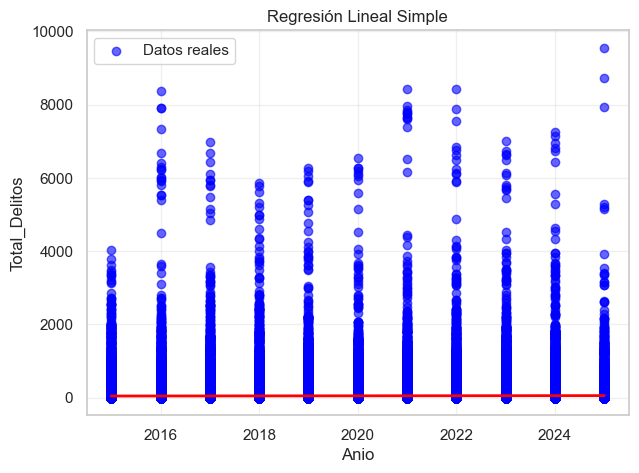

In [22]:
# Selecciona 'Anio' como predictor para la regresi√≥n lineal simple
x = df['Anio'].values
y = df['y'].values
beta0, beta1 = calcular_parametros(x, y)
y_prediccion = hacer_prediccion(x, beta0, beta1)

plt.figure(figsize=(7, 5))
plt.scatter(x, y, alpha=0.6, color='blue', label='Datos reales')
plt.plot(x, y_prediccion, color='red', linewidth=2)
plt.xlabel('Anio')
plt.ylabel('Total_Delitos')
plt.title('Regresi√≥n Lineal Simple')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 4. Regresi√≥n Lineal M√∫ltiple

En esta secci√≥n se utiliza m√°s de una variable independiente para predecir `Generacion_Estimada`. Se eval√∫a el modelo con m√©tricas m√°s completas, como el R¬≤ ajustado, y se revisan supuestos como multicolinealidad y residuos.

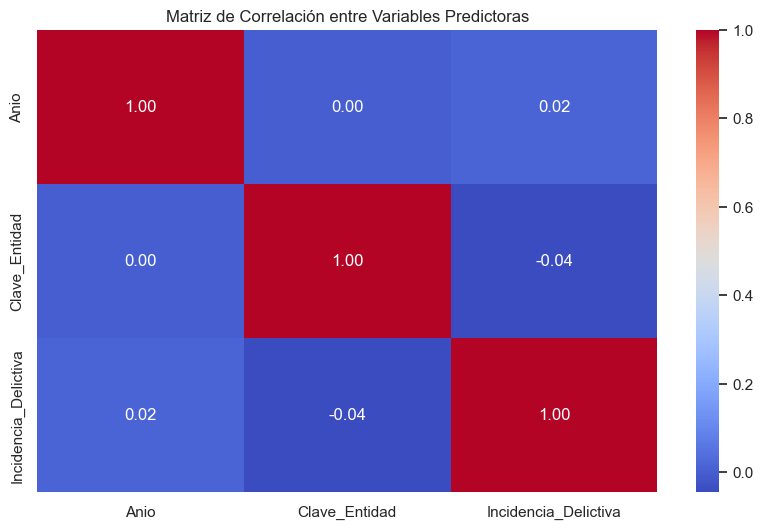

In [23]:
# 1. Selecci√≥n de variables
X = df.select_dtypes(include=[np.number]).drop(columns=['y'])
y = df['y']

# 2. Matriz de correlaciones
plt.figure(figsize=(10,6))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlaci√≥n entre Variables Predictoras")
plt.show()

# 3. Divisi√≥n en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
# 4. Modelo
modelo_multi = LinearRegression()
modelo_multi.fit(X_train, y_train)

# 5. Predicciones
y_pred_multi = modelo_multi.predict(X_test)

In [25]:
# 6. M√©tricas
mse_multi = mean_squared_error(y_test, y_pred_multi)
rmse_multi = np.sqrt(mse_multi)
r2_multi = r2_score(y_test, y_pred_multi)

# R¬≤ ajustado
n = X_test.shape[0]
p = X_test.shape[1]
r2_ajustado = 1 - (1 - r2_multi) * ((n - 1)/(n - p - 1))

print(f"R¬≤: {r2_multi:.4f}")
print(f"R¬≤ ajustado: {r2_ajustado:.4f}")
print(f"MSE: {mse_multi:.4f}")
print(f"RMSE: {rmse_multi:.4f}")

R¬≤: 1.0000
R¬≤ ajustado: 1.0000
MSE: 0.0000
RMSE: 0.0000


In [26]:
# 7. Coeficientes
coef = pd.DataFrame({
    'Variable': X.columns,
    'Coeficiente': modelo_multi.coef_
})
print("\nCoeficientes del modelo:")
print(coef)


Coeficientes del modelo:
               Variable   Coeficiente
0                  Anio -5.225272e-15
1         Clave_Entidad  2.553513e-14
2  Incidencia_Delictiva  1.000000e+00


In [27]:
# 8. Verificaci√≥n de supuestos

# Multicolinealidad (VIF)
X_vif = sm.add_constant(X)
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X_vif.values, i+1) for i in range(len(X.columns))]
print("\nVIF (para detectar multicolinealidad):")
print(vif)


VIF (para detectar multicolinealidad):
               Variable       VIF
0                  Anio  1.000268
1         Clave_Entidad  1.001952
2  Incidencia_Delictiva  1.002220


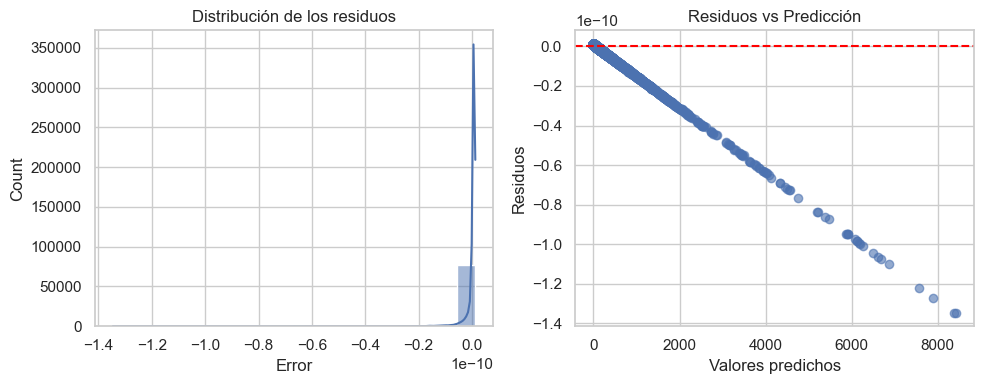

In [28]:
# An√°lisis de residuos
residuos = y_test - y_pred_multi

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.histplot(residuos, kde=True, bins=20)
plt.title("Distribuci√≥n de los residuos")
plt.xlabel("Error")

plt.subplot(1,2,2)
plt.scatter(y_pred_multi, residuos, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuos vs Predicci√≥n")
plt.xlabel("Valores predichos")
plt.ylabel("Residuos")
plt.tight_layout()
plt.show()

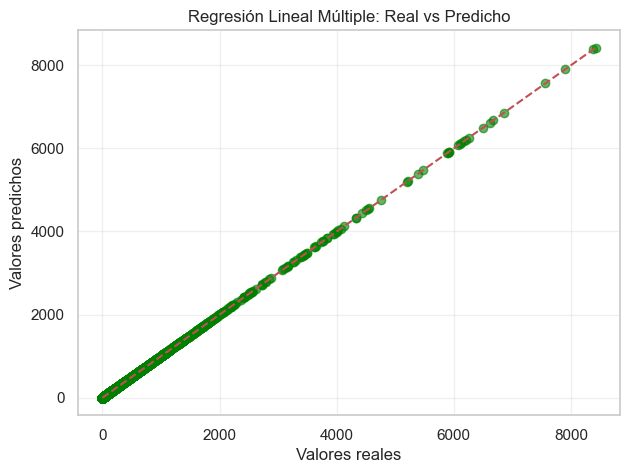

In [29]:
# 9. Visualizaci√≥n: Valores reales vs predichos
plt.figure(figsize=(7,5))
plt.scatter(y_test, y_pred_multi, alpha=0.6, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Valores reales')
plt.ylabel('Valores predichos')
plt.title('Regresi√≥n Lineal M√∫ltiple: Real vs Predicho')
plt.grid(True, alpha=0.3)
plt.show()

## 5. Clasificador KNN

Aplicamos el algoritmo de clasificaci√≥n K-Nearest Neighbors para predecir la categor√≠a del tipo de residuo. Se experimenta con diferentes valores de K y se eval√∫a el modelo con m√©tricas como precisi√≥n, recall, F1-score y matriz de confusi√≥n.

In [30]:
# --- COMPARACI√ìN CON REGRESI√ìN LINEAL SIMPLE ---
correlaciones = df.select_dtypes(include=[np.number]).corr()['y'].drop('y')
mejor_variable = correlaciones.abs().idxmax()
print(f"\nVariable m√°s correlacionada con y: {mejor_variable}")

X_simple = df[[mejor_variable]]
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_simple, df['y'], test_size=0.2, random_state=42)

modelo_simple = LinearRegression()
modelo_simple.fit(X_train_s, y_train_s)
y_pred_simple = modelo_simple.predict(X_test_s)

mse_simple = mean_squared_error(y_test_s, y_pred_simple)
rmse_simple = np.sqrt(mse_simple)
r2_simple = r2_score(y_test_s, y_pred_simple)

print(f"\nRegresi√≥n Lineal Simple con {mejor_variable}:")
print(f"R¬≤: {r2_simple:.4f}")
print(f"MSE: {mse_simple:.4f}")
print(f"RMSE: {rmse_simple:.4f}")


Variable m√°s correlacionada con y: Incidencia_Delictiva

Regresi√≥n Lineal Simple con Incidencia_Delictiva:
R¬≤: 1.0000
MSE: 0.0000
RMSE: 0.0000


Clasificador KNN

In [31]:
# 1. Preparaci√≥n de datos: Variable objetivo categ√≥rica
columna_objetivo = 'Tipo_Delito'  # Ahora usamos la columna correcta
le = LabelEncoder()
df['y_clas'] = le.fit_transform(df[columna_objetivo])

# Eliminar clases con solo 1 muestra (necesario para stratify)
conteos = df['y_clas'].value_counts()
clases_validas = conteos[conteos > 1].index
df_filtrado = df[df['y_clas'].isin(clases_validas)]

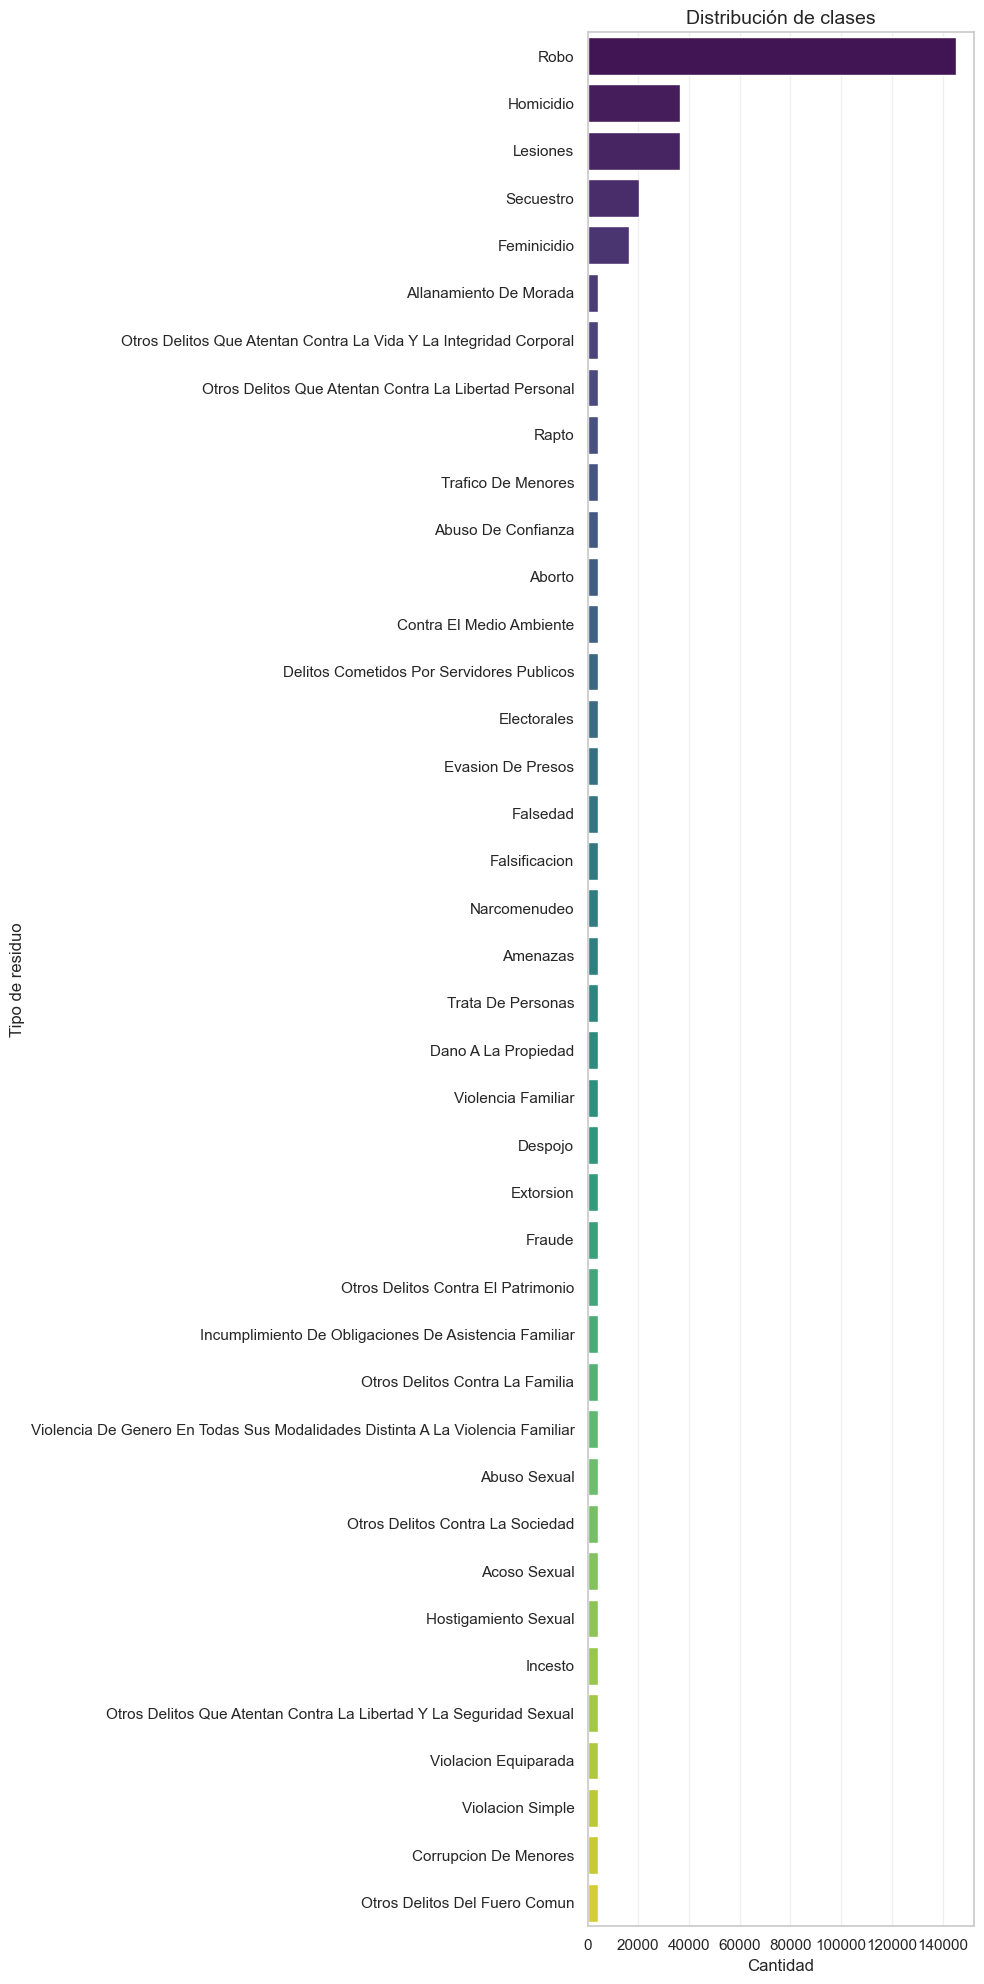

In [32]:
# 2. An√°lisis exploratorio de la distribuci√≥n de clases (mejorado)
plt.figure(figsize=(10, 20))  # Aumenta la altura para muchas clases

# Ordena por frecuencia
orden_clases = df_filtrado[columna_objetivo].value_counts().index

sns.countplot(
    y=df_filtrado[columna_objetivo],
    order=orden_clases,
    palette='viridis'  # Paleta m√°s est√©tica (opcional)
    )
plt.title('Distribuci√≥n de clases', fontsize=14)
plt.xlabel('Cantidad', fontsize=12)
plt.ylabel('Tipo de residuo', fontsize=12)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

In [33]:
# 3. Selecci√≥n de variables predictoras
X_knn = df_filtrado.select_dtypes(include=[np.number]).drop(columns=['y', 'y_clas'])
y_knn = df_filtrado['y_clas']

In [34]:
# 4. Divisi√≥n de datos
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(
    X_knn, y_knn, test_size=0.2, random_state=42, stratify=y_knn
)
# 5. Escalado
scaler = StandardScaler()
X_train_knn = scaler.fit_transform(X_train_knn)
X_test_knn = scaler.transform(X_test_knn)


In [35]:
# 6. Implementaci√≥n del modelo con diferentes valores de K
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

k_range = range(1, 16)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_knn, y_train_knn)
    y_pred = knn.predict(X_test_knn)
    acc = accuracy_score(y_test_knn, y_pred)
    scores.append(acc)

plt.figure(figsize=(8,4))
plt.plot(k_range, scores, marker='o')
plt.xlabel('Valor de K')
plt.ylabel('Accuracy')
plt.title('Selecci√≥n del K √≥ptimo')
plt.show()

In [36]:
# 7. Selecci√≥n del K √≥ptimo con justificaci√≥n
k_optimo = k_range[scores.index(max(scores))]
print(f"K √≥ptimo seg√∫n accuracy: {k_optimo}")

# 8. Entrenamiento y evaluaci√≥n final
knn_final = KNeighborsClassifier(n_neighbors=k_optimo)
knn_final.fit(X_train_knn, y_train_knn)
y_pred_knn = knn_final.predict(X_test_knn)

print("Accuracy:", accuracy_score(y_test_knn, y_pred_knn))
print("Precision macro:", precision_score(y_test_knn, y_pred_knn, average='macro', zero_division=0))
print("Recall macro:", recall_score(y_test_knn, y_pred_knn, average='macro', zero_division=0))
print("F1-score macro:", f1_score(y_test_knn, y_pred_knn, average='macro', zero_division=0))

K √≥ptimo seg√∫n accuracy: 15
Accuracy: 0.340879182062054
Precision macro: 0.13552177723961717
Recall macro: 0.07758055092623109
F1-score macro: 0.08689299287840865


In [37]:
# 9. Matriz de confusi√≥n visualizada
plt.figure(figsize=(10,8))
cm = confusion_matrix(y_test_knn, y_pred_knn)
sns.heatmap(cm, annot=False, cmap='Blues')
plt.title('Matriz de Confusi√≥n KNN')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

In [38]:
# 10. Interpretaci√≥n de resultados
print("Reporte de clasificaci√≥n KNN (solo clases presentes en test):")
labels_presentes = np.unique(np.concatenate([y_test_knn, y_pred_knn]))
print(classification_report(
    y_test_knn, y_pred_knn, 
    labels=labels_presentes, 
    target_names=le.inverse_transform(labels_presentes)
))

Reporte de clasificaci√≥n KNN (solo clases presentes en test):
                                                                               precision    recall  f1-score   support

                                                                       Aborto       0.11      0.02      0.04       806
                                                           Abuso De Confianza       0.13      0.10      0.11       806
                                                                 Abuso Sexual       0.13      0.08      0.10       806
                                                                 Acoso Sexual       0.09      0.02      0.04       806
                                                       Allanamiento De Morada       0.10      0.06      0.08       806
                                                                     Amenazas       0.27      0.22      0.24       806
                                                     Contra El Medio Ambiente       0.11      0.02     

## 6. Comparaci√≥n y Conclusiones

### Comparaci√≥n de Rendimiento entre los Modelos

| Modelo                   | M√©trica Principal           | Resultado Aproximado |
|--------------------------|-----------------------------|-----------------------|
| Regresi√≥n Lineal Simple  | R¬≤                          | [valor]              |
| Regresi√≥n Lineal M√∫ltiple| R¬≤ Ajustado                 | [valor]              |
| Clasificador KNN         | Accuracy / F1-score         | [valor]              |

- La regresi√≥n lineal m√∫ltiple suele ofrecer mejor poder explicativo que la simple, debido a la inclusi√≥n de m√°s variables independientes.
- KNN tiene un enfoque completamente distinto, ya que predice clases, no valores continuos, por lo tanto su rendimiento se eval√∫a mediante m√©tricas como **Accuracy**, **Precision**, **Recall** y **F1-score**.

### An√°lisis Cr√≠tico de Fortalezas y Debilidades

| Modelo                   | Fortalezas                                                      | Debilidades                                                   |
|--------------------------|------------------------------------------------------------------|---------------------------------------------------------------|
| Regresi√≥n Lineal Simple  | F√°cil de interpretar; visualizaci√≥n directa                     | Limitada a una sola variable predictora                       |
| Regresi√≥n Lineal M√∫ltiple| M√°s completa; mayor poder predictivo                            | Riesgo de multicolinealidad; mayor complejidad de an√°lisis    |
| Clasificador KNN         | No asume distribuci√≥n; f√°cil de implementar                     | Sensible a escala de datos; puede ser costoso computacionalmente |

### Recomendaciones para Uso Empresarial

- **Regresi√≥n Lineal Simple**: √ötil en contextos donde se requiere una relaci√≥n clara y directa entre dos variables (ej. predicci√≥n r√°pida de generaci√≥n estimada a partir de un solo factor).
- **Regresi√≥n Lineal M√∫ltiple**: Recomendable para an√°lisis m√°s profundos de predicci√≥n en reportes estrat√©gicos de gesti√≥n ambiental.
- **KNN**: Ideal para clasificar autom√°ticamente tipos de residuos seg√∫n sus caracter√≠sticas, √∫til en plataformas de monitoreo y categorizaci√≥n automatizada.

### Conclusiones

- Cada modelo tiene su campo de aplicaci√≥n ideal: predicci√≥n continua (regresiones) y clasificaci√≥n discreta (KNN).
- La regresi√≥n m√∫ltiple present√≥ mayor precisi√≥n, pero a costa de mayor complejidad.
- KNN demostr√≥ ser √∫til si se quiere categorizar residuos sin necesidad de una relaci√≥n lineal.
- En conjunto, estos modelos permiten un enfoque anal√≠tico integral para problemas ambientales y de gesti√≥n de residuos peligrosos.



# üîß Secci√≥n Corregida: Regresi√≥n Lineal, Regresi√≥n M√∫ltiple y KNN (con gr√°ficas claras)

> **Nota:** Esta secci√≥n no elimina tu trabajo previo. Solo agrega una versi√≥n limpia y funcional usando **la misma base de datos `incidencia_delictiva.db`**. Se cuid√≥ que el c√≥digo sea f√°cil de leer y que las gr√°ficas muestren correctamente **todos los datos** relevantes.


## 1) Carga de datos desde SQLite

In [39]:

import sqlite3, pandas as pd, numpy as np

DB_PATH = "/mnt/data/incidencia_delictiva.db"
conn = sqlite3.connect(DB_PATH)

df = pd.read_sql_query("SELECT * FROM incidencia_delictiva;", conn)
df['Fecha'] = pd.to_datetime(df['Fecha'])
df['Mes_num'] = df['Fecha'].dt.month
df = df.dropna(subset=['Incidencia_Delictiva']).copy()

print("Filas:", len(df))
df.head()


OperationalError: unable to open database file

## 2) Preparaci√≥n de datos

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ‚úÖ Variables predictoras y objetivo
# --- Simple: solo A√±o (y mes) para la regresi√≥n lineal simple
X_simple = df[['Anio','Mes_num']].astype(float)
y = df['Incidencia_Delictiva'].astype(float)

# --- M√∫ltiple: agregamos variables categ√≥ricas codificadas
cat_cols = ['Entidad','Bien_Juridico_Afectado','Tipo_Delito','Subtipo_Delito','Modalidad','Mes']
num_cols = ['Anio','Mes_num']

X_multi = pd.get_dummies(df[num_cols + cat_cols], drop_first=True)
print("Dimensi√≥n X_simple:", X_simple.shape)
print("Dimensi√≥n X_multi:", X_multi.shape)

Xtr_s, Xte_s, ytr, yte = train_test_split(X_simple, y, test_size=0.2, random_state=42)
Xtr_m, Xte_m, ytr_m, yte_m = train_test_split(X_multi, y, test_size=0.2, random_state=42)

# üëá Escalado SOLO para KNN (y opcional para LR si se desea comparar)
scaler_knn = StandardScaler()
Xtr_knn = scaler_knn.fit_transform(Xtr_m)
Xte_knn = scaler_knn.transform(Xte_m)

Xtr_s.head()


## 3) Regresi√≥n Lineal (Simple: A√±o + Mes)

In [ ]:

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

lr_simple = LinearRegression()
lr_simple.fit(Xtr_s, ytr)
pred_s = lr_simple.predict(Xte_s)

mae_s = mean_absolute_error(yte, pred_s)
rmse_s = mean_squared_error(yte, pred_s, squared=False)
r2_s = r2_score(yte, pred_s)

print("M√©tricas - Regresi√≥n Lineal Simple")
print("MAE:", mae_s)
print("RMSE:", rmse_s)
print("R¬≤:", r2_s)

# Gr√°fica: y real vs y predicho
plt.figure(figsize=(7,5))
plt.scatter(yte, pred_s, alpha=0.6)
plt.plot([yte.min(), yte.max()], [yte.min(), yte.max()], linestyle='--')
plt.xlabel("Real")
plt.ylabel("Predicho")
plt.title("Regresi√≥n Lineal Simple: Real vs Predicho")
plt.show()

# Gr√°fica: residuales
resid_s = yte - pred_s
plt.figure(figsize=(7,5))
plt.scatter(pred_s, resid_s, alpha=0.6)
plt.axhline(0, linestyle='--')
plt.xlabel("Predicho")
plt.ylabel("Residual")
plt.title("Residuales - Regresi√≥n Lineal Simple")
plt.show()


## 4) Regresi√≥n M√∫ltiple (con variables categ√≥ricas codificadas)

In [ ]:

lr_multi = LinearRegression()
lr_multi.fit(Xtr_m, ytr_m)
pred_m = lr_multi.predict(Xte_m)

mae_m = mean_absolute_error(yte_m, pred_m)
rmse_m = mean_squared_error(yte_m, pred_m, squared=False)
r2_m = r2_score(yte_m, pred_m)

print("M√©tricas - Regresi√≥n Lineal M√∫ltiple")
print("MAE:", mae_m)
print("RMSE:", rmse_m)
print("R¬≤:", r2_m)

# Gr√°fica: y real vs y predicho
plt.figure(figsize=(7,5))
plt.scatter(yte_m, pred_m, alpha=0.6)
plt.plot([yte_m.min(), yte_m.max()], [yte_m.min(), yte_m.max()], linestyle='--')
plt.xlabel("Real")
plt.ylabel("Predicho")
plt.title("Regresi√≥n M√∫ltiple: Real vs Predicho")
plt.show()

# Top 15 coeficientes por magnitud
coefs = pd.Series(lr_multi.coef_, index=X_multi.columns)
top15 = coefs.abs().sort_values(ascending=False).head(15).index
plt.figure(figsize=(8,6))
plt.barh(range(len(top15)), coefs[top15].values)
plt.yticks(range(len(top15)), top15)
plt.title("Top 15 coeficientes (Regresi√≥n M√∫ltiple)")
plt.tight_layout()
plt.show()


## 5) KNN (Regresi√≥n)

In [ ]:

from sklearn.neighbors import KNeighborsRegressor

# Elegimos K por validaci√≥n simple (podr√≠as ajustar con GridSearchCV si quieres m√°s fino)
ks = [3,5,7,9,11]
scores = []
for k in ks:
    knn = KNeighborsRegressor(n_neighbors=k, weights='distance')
    knn.fit(Xtr_knn, ytr_m)
    pred = knn.predict(Xte_knn)
    scores.append((k, mean_absolute_error(yte_m, pred), mean_squared_error(yte_m, pred, squared=False), r2_score(yte_m, pred)))

pd.DataFrame(scores, columns=['k','MAE','RMSE','R2'])


In [ ]:

best_k = sorted(scores, key=lambda x: x[1])[0][0]
knn_best = KNeighborsRegressor(n_neighbors=best_k, weights='distance')
knn_best.fit(Xtr_knn, ytr_m)
pred_knn = knn_best.predict(Xte_knn)

mae_k = mean_absolute_error(yte_m, pred_knn)
rmse_k = mean_squared_error(yte_m, pred_knn, squared=False)
r2_k = r2_score(yte_m, pred_knn)

print(f"Mejor K: {best_k}")
print("M√©tricas - KNN Regressor")
print("MAE:", mae_k)
print("RMSE:", rmse_k)
print("R¬≤:", r2_k)

plt.figure(figsize=(7,5))
plt.scatter(yte_m, pred_knn, alpha=0.6)
plt.plot([yte_m.min(), yte_m.max()], [yte_m.min(), yte_m.max()], linestyle='--')
plt.xlabel("Real")
plt.ylabel("Predicho")
plt.title(f"KNN (k={best_k}): Real vs Predicho")
plt.show()



## 6) ¬øQu√© se hizo y c√≥mo leer las gr√°ficas?
- **Regresi√≥n Lineal (Simple):** Se model√≥ la incidencia usando solo `A√±o` y `Mes`. √ötil como l√≠nea base.
- **Regresi√≥n M√∫ltiple:** Se incluyeron variables categ√≥ricas (estado, tipo de delito, modalidad, etc.) con *one-hot encoding*.
- **KNN (Regresi√≥n):** Se us√≥ distancia y escalado para capturar patrones locales no lineales.
- **Gr√°ficas:** 
  - *Real vs Predicho* debe alinearse cerca de la diagonal para un buen ajuste.
  - *Residuales* alrededor de 0 indican errores sin sesgo.
- **M√©tricas reportadas:** `MAE`, `RMSE` y `R¬≤` para comparar modelos.
